In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
train_df.head()

,Id,Therapy Hours,Initial Health Score,Lifestyle Activities,Average Sleep Hours,Follow-Up Sessions,Recovery Index
0,9255,5,49,No,7,5,36
1,1562,2,48,Yes,7,6,25
2,1671,2,81,No,7,2,59
3,6088,2,46,No,6,1,22
4,6670,8,47,No,9,0,40


In [4]:
train_df.isnull().sum()
test_df.isnull().sum()

Id                      0
Therapy Hours           0
Initial Health Score    0
Lifestyle Activities    0
Average Sleep Hours     0
Follow-Up Sessions      0
dtype: int64

In [5]:
train_df["Lifestyle Activities"] = train_df["Lifestyle Activities"].map({"No": 0, "Yes": 1})
test_df["Lifestyle Activities"]  = test_df["Lifestyle Activities"].map({"No": 0, "Yes": 1})

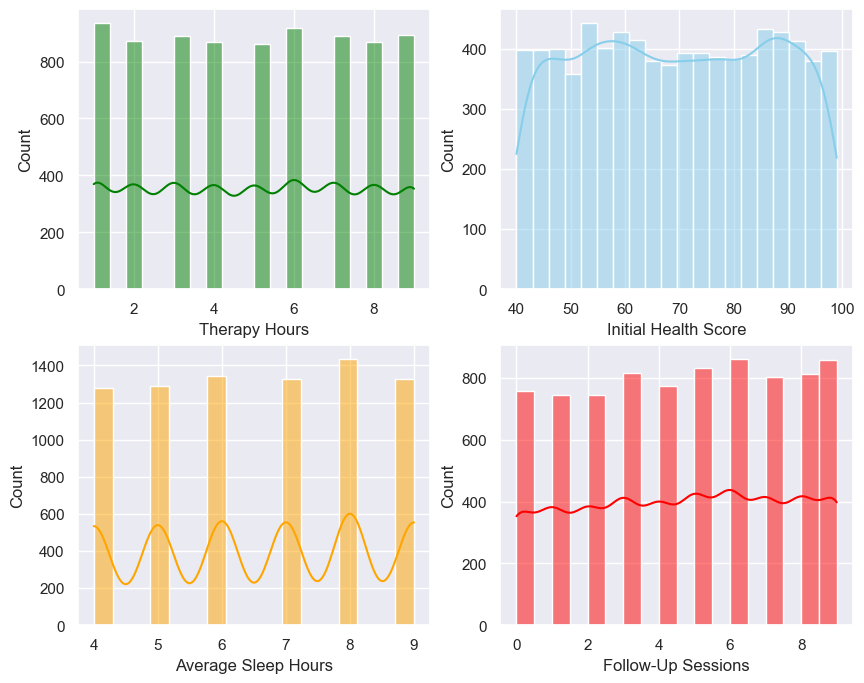

In [6]:
# Checking the Distribution of Data
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=train_df, x="Therapy Hours", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=train_df, x="Initial Health Score", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=train_df, x="Average Sleep Hours", kde=True, ax=axs[1, 0], color='orange')
sns.histplot(data=train_df, x="Follow-Up Sessions", kde=True, ax=axs[1, 1], color='red');

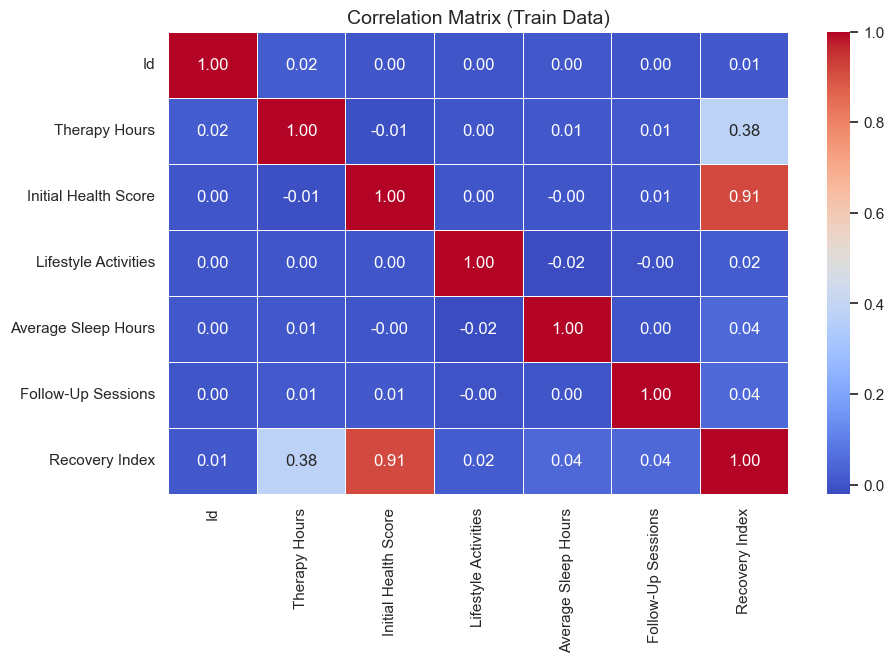

In [7]:
corr_matrix = train_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Train Data)", fontsize=14)
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

X_train = train_df.drop(columns=["Recovery Index"])
y_train = train_df["Recovery Index"]

X_test = test_df.drop(columns=["Id"])

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=["Id"]))
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Hyperparameter grid for Lasso
paramsLasso = {
    'alpha': np.logspace(-4, 1, 100),  # Range from 0.0001 to 10
    'max_iter': [1000, 2000, 3000, 5000],
    'tol': [1e-4, 1e-3, 1e-2],
    'selection': ['cyclic', 'random']
}

# RandomizedSearchCV for tuning
lasso_search = RandomizedSearchCV(
    Lasso(random_state=1), 
    paramsLasso, 
    cv=5,              
    scoring='r2',      
    n_iter=20,         
    random_state=1
)
lasso_search.fit(X_train_scaled, y_train)

print("Best Estimator:", lasso_search.best_estimator_)
print("Best R² Score:", lasso_search.best_score_)
print("Best Params:", lasso_search.best_params_)
print("Best Index:", lasso_search.best_index_)

# Train final model with best params
lasso_regressor = Lasso(
    alpha=lasso_search.best_params_['alpha'],
    max_iter=lasso_search.best_params_['max_iter'],
    tol=lasso_search.best_params_['tol'],
    selection=lasso_search.best_params_['selection'],
    random_state=1
)
lasso_regressor.fit(X_train_scaled, y_train)

# Calculate Cross-Validation Score
lasso_cv_scores = cross_val_score(lasso_regressor, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nLasso Cross-Validation R² Scores:", lasso_cv_scores)
print("Mean Lasso CV R² Score:", np.mean(lasso_cv_scores))

# Predict on test set
y_pred = lasso_regressor.predict(X_test_scaled)
submission_lasso = pd.DataFrame({
    "Id": test_df["Id"],
    "Recovery Index": y_pred
})
submission_lasso.to_csv("submission/submission_lasso.csv", index=False)

Best Estimator: Lasso(alpha=np.float64(0.000509413801481638), max_iter=5000, random_state=1,
      selection='random')
Best R² Score: 0.9886614207917124
Best Params: {'tol': 0.0001, 'selection': 'random', 'max_iter': 5000, 'alpha': np.float64(0.000509413801481638)}
Best Index: 10

Lasso Cross-Validation R² Scores: [0.9887161  0.98838457 0.98891386 0.98828765 0.98900492]
Mean Lasso CV R² Score: 0.9886614207917124


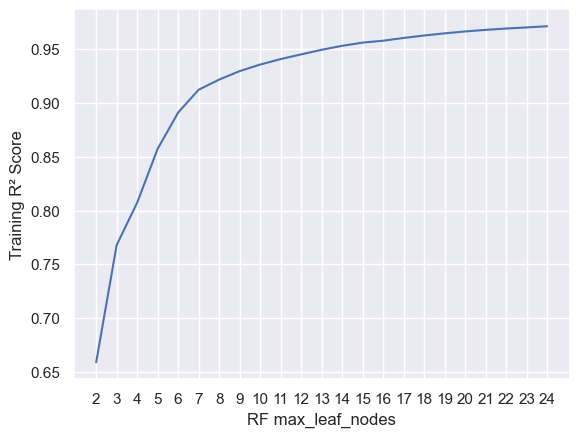


RandomForest Cross-Validation R² Scores: [0.97010096 0.97057202 0.96968418 0.96740754 0.97191943]
Mean RandomForest CV R² Score: 0.9699368269034008


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

scoreListRF = []
for i in range(2, 25):
    RFregressor = RandomForestRegressor(
        n_estimators=1000, random_state=1, max_leaf_nodes=i
    )
    RFregressor.fit(X_train_scaled, y_train)

    preds = RFregressor.predict(X_test_scaled)

    scoreListRF.append(RFregressor.score(X_train_scaled, y_train))

# Plot training R² scores across leaf nodes
plt.plot(range(2, 25), scoreListRF)
plt.xticks(np.arange(2, 25, 1))
plt.xlabel("RF max_leaf_nodes")
plt.ylabel("Training R² Score")
plt.show()

# Get best regressor
best_leaf_nodes = np.argmax(scoreListRF) + 2
best_RF = RandomForestRegressor(
    n_estimators=1000, random_state=1, max_leaf_nodes=best_leaf_nodes
)
best_RF.fit(X_train_scaled, y_train)

# Caculate Cross-Validation Score
rf_cv_scores = cross_val_score(best_RF, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nRandomForest Cross-Validation R² Scores:", rf_cv_scores)
print("Mean RandomForest CV R² Score:", np.mean(rf_cv_scores))

# Predict Recovery Index for test_df
test_predictions = best_RF.predict(X_test_scaled)
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "Recovery Index": test_predictions
})
submission.to_csv("submission/submission_rf.csv", index=False)


In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Hyperparameter grid
paramsGB = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [1, 2, 3, 4, 5],
    'subsample': [0.5, 1],
    'max_leaf_nodes': [2, 5, 10, 20, 30, 40, 50]
}

# RandomizedSearchCV for tuning
GB = RandomizedSearchCV(
    GradientBoostingRegressor(), 
    paramsGB, 
    cv=5,              
    scoring='r2',      
    n_iter=20,         
    random_state=1
)
GB.fit(X_train_scaled, y_train)

print("Best Estimator:", GB.best_estimator_)
print("Best R² Score:", GB.best_score_)
print("Best Params:", GB.best_params_)
print("Best Index:", GB.best_index_)

# Train final model with best params
GBregressor = GradientBoostingRegressor(
    subsample=GB.best_params_['subsample'],
    n_estimators=GB.best_params_['n_estimators'],
    max_depth=GB.best_params_['max_depth'],
    max_leaf_nodes=GB.best_params_['max_leaf_nodes'],
    random_state=1
)
GBregressor.fit(X_train_scaled, y_train)

# Calculate Cross-Validation Score
gb_cv_scores = cross_val_score(GBregressor, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nGradientBoosting Cross-Validation R² Scores:", gb_cv_scores)
print("Mean GradientBoosting CV R² Score:", np.mean(gb_cv_scores))

# Predict on test set
y_pred = GBregressor.predict(X_test_scaled)
submission_gb = pd.DataFrame({
    "Id": test_df["Id"],
    "Recovery Index": y_pred
})
submission_gb.to_csv("submission/submission_gb.csv", index=False)

Best Estimator: GradientBoostingRegressor(max_leaf_nodes=20, n_estimators=300, subsample=1)
Best R² Score: 0.987964422906819
Best Params: {'subsample': 1, 'n_estimators': 300, 'max_leaf_nodes': 20, 'max_depth': 3}
Best Index: 18

GradientBoosting Cross-Validation R² Scores: [0.98793579 0.98781763 0.98809527 0.98750253 0.9884667 ]
Mean GradientBoosting CV R² Score: 0.987963583562891


In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Hyperparameter grid for XGBoost
paramsXGB = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

XGB_search = RandomizedSearchCV(
    XGBRegressor(random_state=1), 
    paramsXGB, 
    cv=5,              
    scoring='r2',      
    n_iter=20,         
    random_state=1,
    n_jobs=-1 
)
XGB_search.fit(X_train_scaled, y_train)

print("Best Estimator:", XGB_search.best_estimator_)
print("Best R² Score:", XGB_search.best_score_)
print("Best Params:", XGB_search.best_params_)
print("Best Index:", XGB_search.best_index_)

# Train final model with best params
XGBregressor = XGBRegressor(
    n_estimators=XGB_search.best_params_['n_estimators'],
    max_depth=XGB_search.best_params_['max_depth'],
    learning_rate=XGB_search.best_params_['learning_rate'],
    subsample=XGB_search.best_params_['subsample'],
    colsample_bytree=XGB_search.best_params_['colsample_bytree'],
    gamma=XGB_search.best_params_['gamma'],
    random_state=1,
    n_jobs=-1
)
XGBregressor.fit(X_train_scaled, y_train)

# Calculate Cross-Validation Score
xgb_cv_scores = cross_val_score(XGBregressor, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nXGBoost Cross-Validation R² Scores:", xgb_cv_scores)
print("Mean XGBoost CV R² Score:", np.mean(xgb_cv_scores))

# Predict on test set
y_pred_xgb = XGBregressor.predict(X_test_scaled)

# Create submission file
submission_xgb = pd.DataFrame({
    "Id": test_df["Id"],
    "Recovery Index": y_pred_xgb
})
submission_xgb.to_csv("submission/submission_xgb.csv", index=False)

Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)
Best R² Score: 0.9882345795631409
Best Params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best Index: 4

XGBoost Cross-Validation R² Scores: [0.98815447 0.9880783  0.9